In [49]:
df<-read.csv("/kaggle/input/sa2-statistical-dataset-samples/Salary_Data.csv")

In [50]:
head(df)

,YearsExperience,Salary
,<dbl>,<dbl>
1,1.1,39343
2,1.3,46205
3,1.5,37731
4,2.0,43525
5,2.2,39891
6,2.9,56642


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  37731   56721   65237   76003  100545  122391 

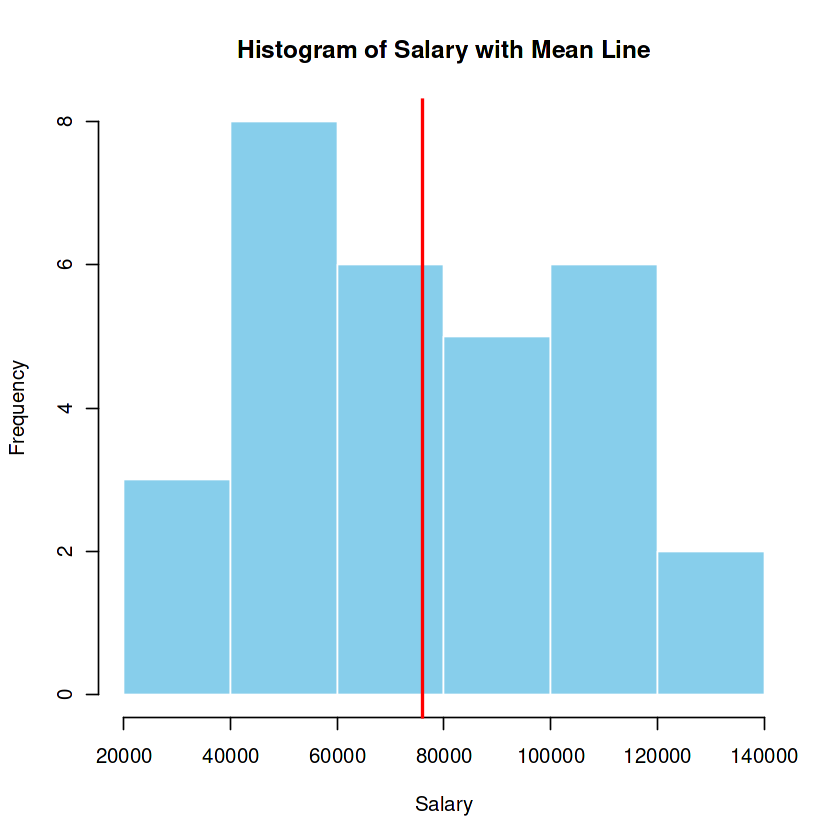

In [51]:
hist(df$Salary,
     col = "skyblue",
     border = "white",
     main = "Histogram of Salary with Mean Line",
     xlab = "Salary",
     ylab = "Frequency")

abline(v = mean(df$Salary), col = "red", lwd = 2)

summary(df$Salary)

> Let's normalize our target variable for our model fitting by using log transformation. This will result for better model as lienar regression works better for this type of distribution

In [52]:
# Normalize the target and define predictor
df$Salary <- log(df$Salary)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.54   10.95   11.09   11.17   11.52   11.71 

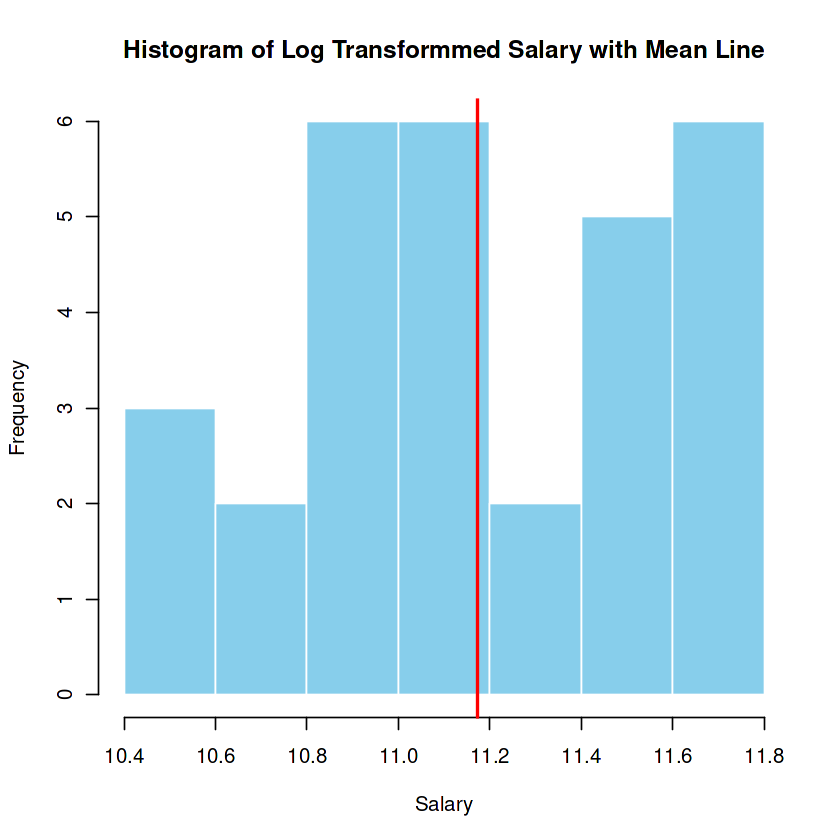

In [53]:
hist(df$Salary,
     col = "skyblue",
     border = "white",
     main = "Histogram of Log Transformmed Salary with Mean Line",
     xlab = "Salary",
     ylab = "Frequency")

abline(v = mean(df$Salary), col = "red", lwd = 2)

summary(df$Salary)

# Data Exploration for evaluating Key Assumptions of Linear Regression

`geom_smooth()` using formula = 'y ~ x'


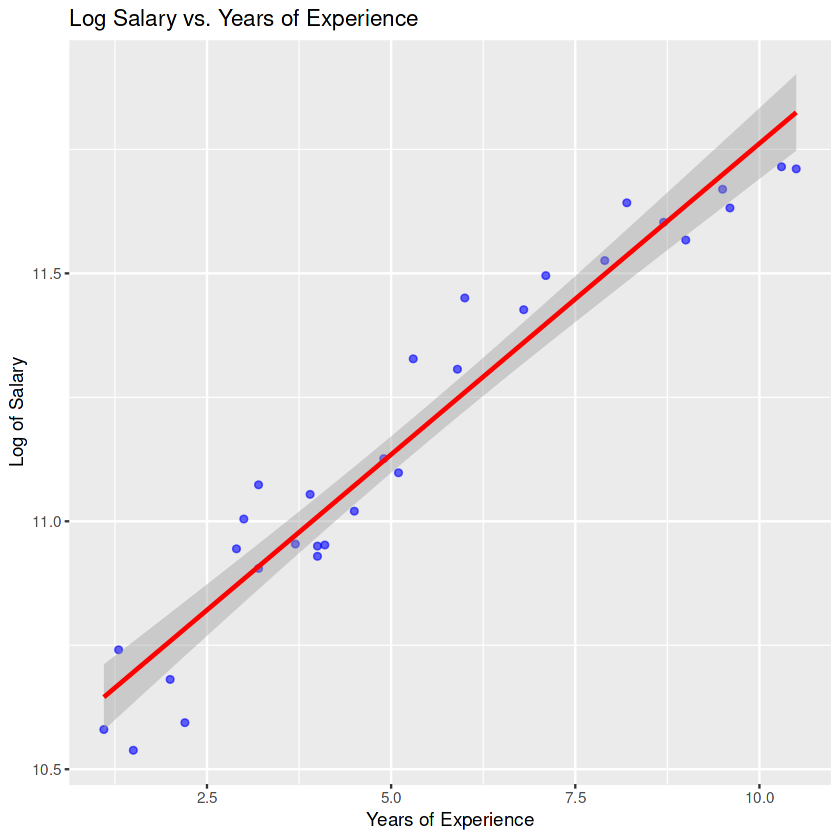

In [54]:
library(ggplot2)

ggplot(df, aes(x =YearsExperience , y = Salary)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_smooth(method = "lm", color = "red") +
  labs(title = "Log Salary vs. Years of Experience",
       x = "Years of Experience",
       y = "Log of Salary")


In [55]:
cat("Correlation of Predictor and Target Variable is:", cor(df$Salary,df$YearsExperience))

Correlation of Predictor and Target Variable is: 0.9653844

> The Salary vs Years of Expereince plot and the Correlation value shows that the relationship between our predictor and target variable follows linearity.

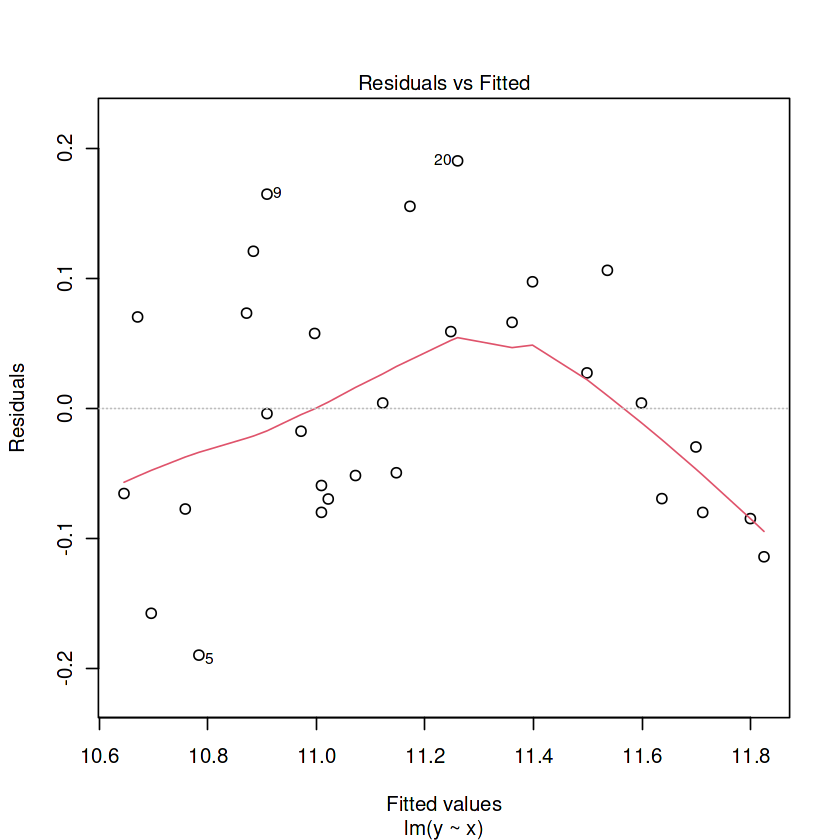

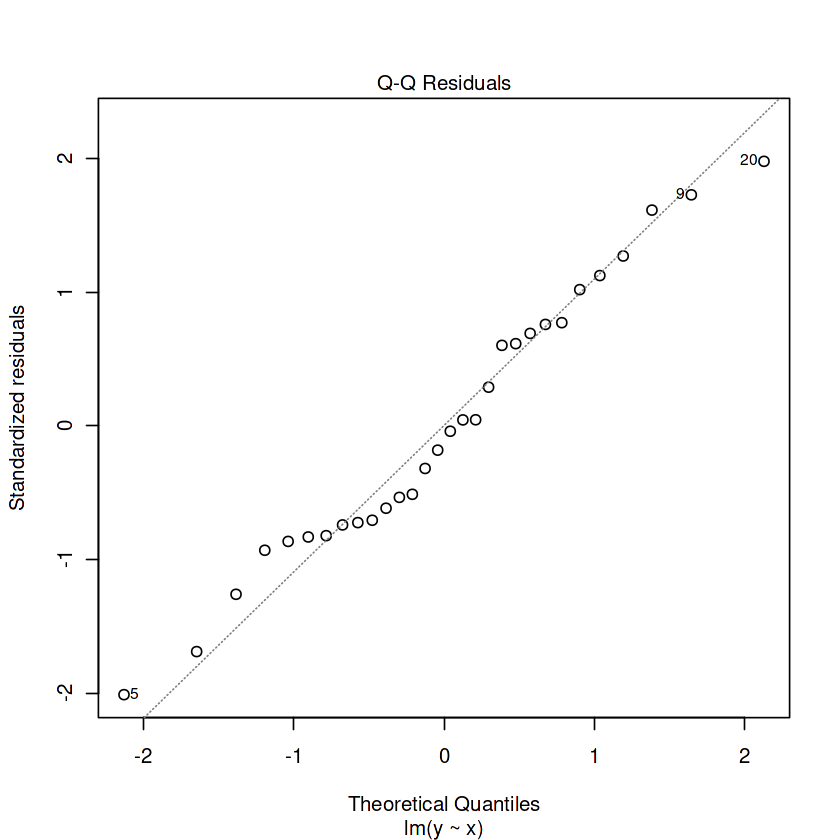

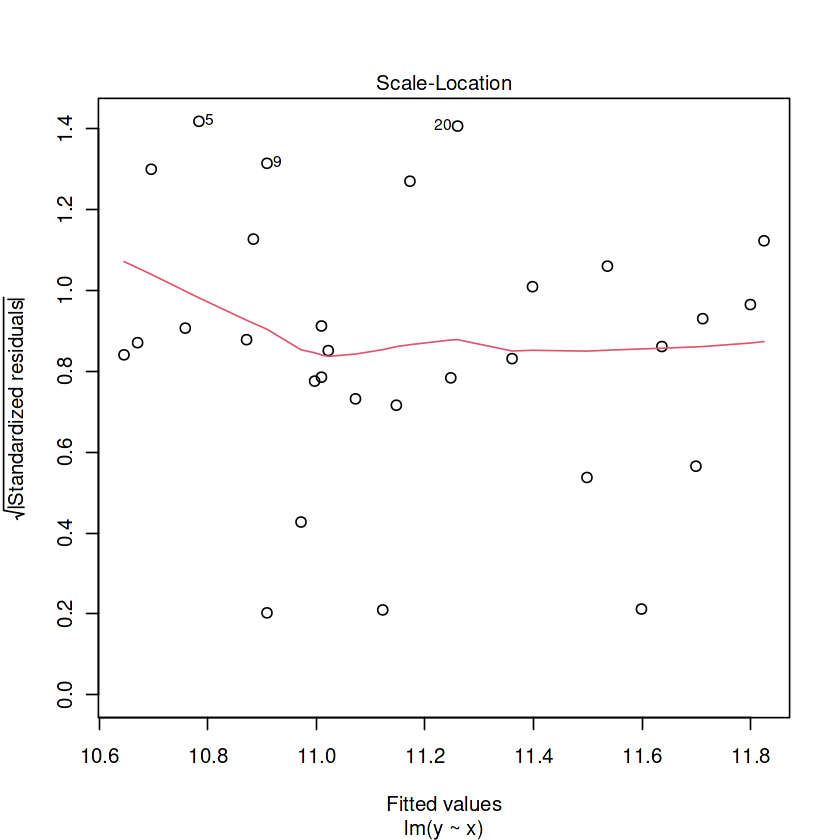

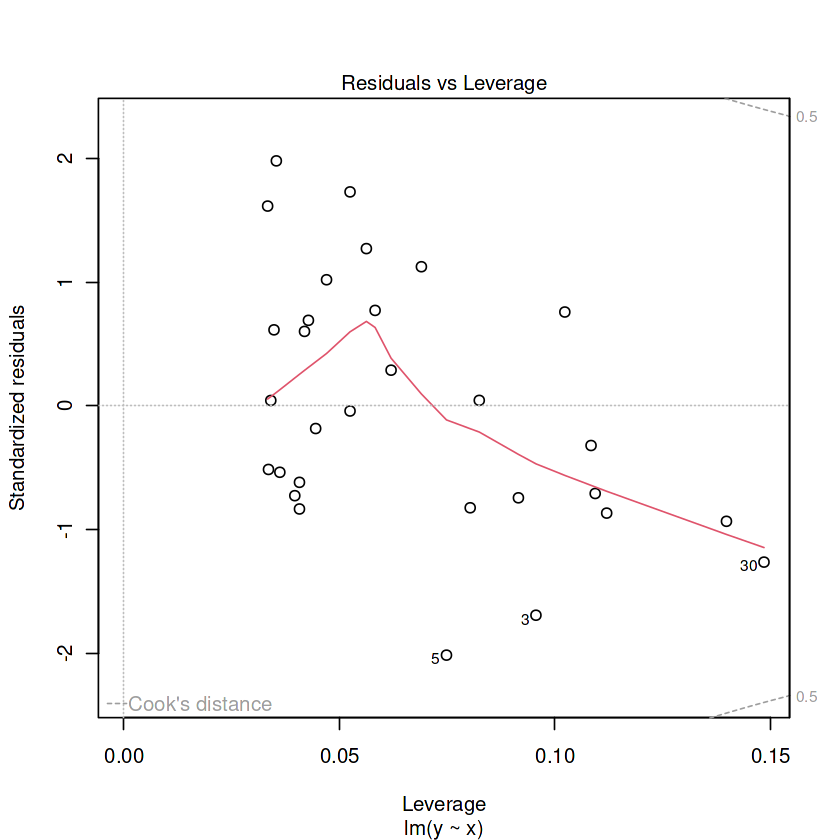

In [56]:
y<-df$Salary
x<-df$YearsExperience

lr_model<-lm(y~x)
plot(lr_model)


> Residuals vs. fitted values - The points are randomly scattered or no pattern around horizontal line near zero, it suggests thatthe assumptions are met for Homoscedasticity 


> Q-Q Residuals- Helps us to assess the normality test, which in our case the datapoints followed the plotted line with no significant outliers

> Scale Location - It assess homoscedasticity .As we can see the residuals have constant spread regardless of the predicted value



> Residuals vs Leverage- is used to identify influential observations.In our observed plot, there is no influential points because there is no points tha  fall outside of the cooks distance.

### Since all of the assumptions are met for Linear Regression, we can proceed on using this model

In [57]:
summary(lr_model)


Call:
lm(formula = y ~ x)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18949 -0.06946 -0.01068  0.06932  0.19029 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.507402   0.038443  273.33   <2e-16 ***
x            0.125453   0.006406   19.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09789 on 28 degrees of freedom
Multiple R-squared:  0.932,	Adjusted R-squared:  0.9295 
F-statistic: 383.6 on 1 and 28 DF,  p-value: < 2.2e-16


*Model Interpretation*

y = 10.507402+0.125453*x 

When the person has no experience = 0 the the salary will be When  the log-salary is expected to be 10.507402 or exp(Intercept) =$36585.31

So, for every one unit increase in experience, the  salary increases by 0.125 or exp(0.125) = 1.13 - 1 x 100 = 13%

> Let's use Bootstrap Resampling method to our model (Linear Regression)

In [58]:
m <- 5000
n <- nrow(df)
b0 <- lr_model$coeff[1]; b1 <- lr_model$coeff[2]

## run bootstrap of cases
out <- replicate(m, expr={
i <- sample(1:n, replace=TRUE, size=n)
xstar <- x[i]
ystar <- y[i]
Lb <- lm(ystar ~ xstar)
s <- summary(Lb)$sigma
c(Lb$coeff[1], slope=Lb$coeff[2], s=s)
})

In [59]:
bootCases <- t(out) #bootstrap resampled estimates
meanCases <- colMeans(bootCases) # average of the bootstrap resampled estimates 
sdCases <- apply(bootCases, 2, "sd") # standard deviation of the bootstrap estimates

In [60]:
summary_table <- data.frame(
  Parameter = c("Intercept", "Slope", "Residual SE"),
  Mean_Estimate = round(meanCases, 5),
  Std_Error = round(sdCases, 5)
)

print(summary_table, row.names = TRUE)


              Parameter Mean_Estimate Std_Error
(Intercept)   Intercept      10.50680   0.04202
slope.xstar       Slope       0.12583   0.00655
s           Residual SE       0.09393   0.01059


In [61]:
biasInt <- mean(bootCases[,1] - b0) #bias for intercept
biasSlope <- mean(bootCases[,2] - b1) #bias for slope

In [62]:
intercept_bootstrap<-mean(bootCases[,1])
slope_bootstrap<-mean(bootCases[,2])

results_matrix <- rbind(
  estimate = c(intercept_bootstrap, slope_bootstrap),
  bias = c(biasInt, biasSlope),
  se = sdCases[1:2],
  cv = c(biasInt, biasSlope) / sdCases[1:2]
)

results_df <- as.data.frame(t(results_matrix))
colnames(results_df) <- c("Estimate", "Bias", "SE", "CV")
rownames(results_df) <- c("Intercept", "Slope")

print(results_df)


            Estimate          Bias          SE          CV
Intercept 10.5068000 -0.0006018815 0.042017994 -0.01432438
Slope      0.1258343  0.0003814496 0.006548343  0.05825132


*Bootstrap Interpretation*

y = 10.5066276+0.1259256*x

When the person has no experience = 0  the salary will be log 10.5066276 or exp(10.5066276) = $36556.99

So, for every one unit increase in experience, the salary increases by  0.1259256 or exp 0.1259256) = 1.13 - 1 x 100 = 13% as well

> As we can see, there is almost no difference between the original estimates from our linear model and those obtained after resampling using the Bootstrap method. From the bias of -0.0007742651, it shows that our estimated intercept is less than of this amount from the original model, which is very low. Followed by the standard error of 0.04 for intercept and 0 for slope indicates that the model is well fit and the CV measures the bias in units of se. According to the bootstrap, the parameter estimates are almost unbiased

> This suggests that our model estimates are stable and not overly sensitive to the specific sample used

# Evaluating the Model Performance

In [63]:
y_true <- y                 
y_pred <- predict(lr_model)  # Predicted log-salaries from linear model

In [64]:
y_pred

1        2        3        4        5        6        7        8 
10.64540 10.67049 10.69558 10.75831 10.78340 10.87122 10.88376 10.90885 
       9       10       11       12       13       14       15       16 
10.90885 10.97158 10.99667 11.00921 11.00921 11.02176 11.07194 11.12212 
      17       18       19       20       21       22       23       24 
11.14721 11.17230 11.24757 11.26012 11.36048 11.39812 11.49848 11.53612 
      25       26       27       28       29       30 
11.59884 11.63648 11.69920 11.71175 11.79957 11.82466

In [65]:
y_true

[1] 10.58007 10.74084 10.53824 10.68109 10.59391 10.94451 11.00460 10.90495
 [9] 11.07357 10.95412 11.05434 10.92942 10.95005 10.95223 11.02045 11.12635
[17] 11.09785 11.32766 11.30668 11.45041 11.42669 11.49550 11.52586 11.64230
[25] 11.60305 11.56724 11.66966 11.63191 11.71498 11.71073

In [66]:
rmse <- sqrt(mean((y_true - y_pred)^2))
mae <- mean(abs(y_true - y_pred))
SStot <- sum((y_true - mean(y_true))^2)
SSres <- sum((y_true - y_pred)^2)
r_squared <- 1 - SSres/SStot


In [67]:
cat("Linear Regression Evaluation Metrics:\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("MAE:", round(mae, 4), "\n")
cat("R-squared:", round(r_squared, 4), "\n")



Linear Regression Evaluation Metrics:
RMSE: 0.0946 
MAE: 0.0798 
R-squared: 0.932 


> The model predictions deviate from the actual (log-transformed) salary by about 0.0946 units as shown by RMSE. While the MAE shows the average absolute difference between predicted and actual values is 0.0798, that shows fairly accurate predictions. Lastly, the R-squared is 0.932 which is high and good indication that our model explain the data very well.



# Applying Bootstrap to Assess Regression Trees

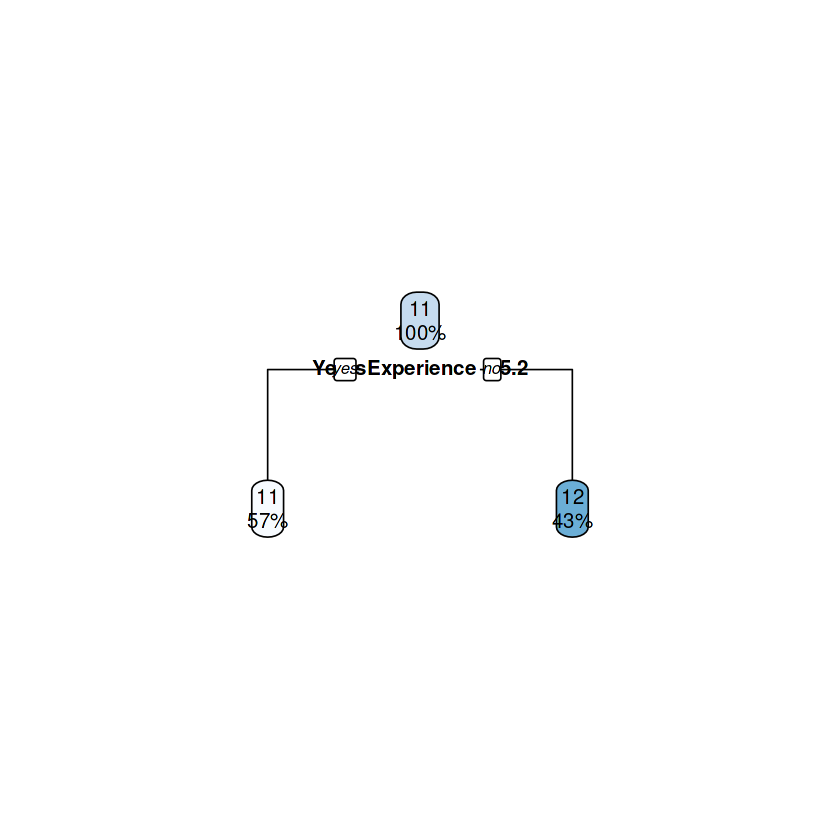

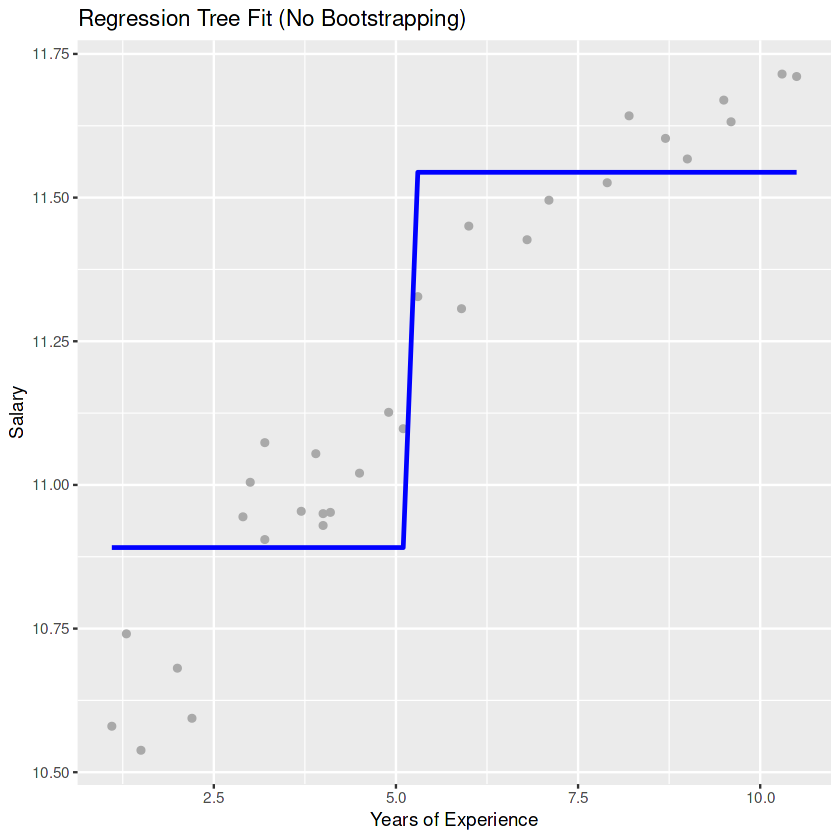

In [68]:

# Initial Model without Bootstrapping 

library(rpart)
library(rpart.plot)
library(ggplot2)


tree_model <- rpart(Salary ~ YearsExperience, data = df)


rpart.plot(tree_model)

df$pred_salary <- predict(tree_model, newdata = df)

ggplot(df, aes(x = YearsExperience, y = Salary)) +
  geom_point(color = "darkgray") +
  geom_line(aes(y = pred_salary), color = "blue", size = 1) +
  labs(title = "Regression Tree Fit (No Bootstrapping)",
       x = "Years of Experience",
       y = "Salary")


In [69]:
library(rpart)
library(Metrics)

set.seed(123)
m <- 500
n <- nrow(df)

all_preds <- matrix(NA, nrow = n, ncol = m)

for (i in 1:m) {
  indices <- sample(1:n, replace = TRUE)
  train_data <- df[indices, ]
  tree_model <- rpart(Salary ~ YearsExperience, data = train_data)
  all_preds[, i] <- predict(tree_model, newdata = df)
}

avg_preds <- rowMeans(all_preds)
bias_vector <- avg_preds - df$Salary
mean_bias <- mean(bias_vector)
bias_rmse <- sqrt(mean((bias_vector)^2))

cat("Mean Bias:", round(mean_bias, 3), "\n")
cat("RMSE of Bias:", round(bias_rmse, 3), "\n")



Mean Bias: 0.002 
RMSE of Bias: 0.138 


##### Mean Bias: 0.002 

This is the average difference between the predicted salary (from the bootstrap-averaged regression tree) and the actual salary.

##### RMSE of Bias: 0.138 

The typical prediction from the bootstrapped regression tree differs from the actual salary by about 0.138 units, regardless of whether it over- or underestimates.

In [70]:
library(Metrics)
set.seed(123)
m <- 5000
n <- nrow(df)


rmse_vals <- numeric(m)
mae_vals <- numeric(m)
r2_vals <- numeric(m)

for (i in 1:m) {
  indices <- sample(1:n, replace = TRUE)
  train_data <- df[indices, ]
  
  oob_indices <- setdiff(1:n, unique(indices))
  if (length(oob_indices) < 2) next  
  test_data <- df[oob_indices, ]
  
  tree_model <- rpart(Salary ~ YearsExperience, data = train_data)
  
  preds <- predict(tree_model, newdata = test_data)
  
  rmse_vals[i] <- rmse(test_data$Salary, preds)
  mae_vals[i] <- mae(test_data$Salary, preds)
  r2_vals[i] <- 1 - sum((test_data$Salary - preds)^2) / sum((test_data$Salary - mean(test_data$Salary))^2)
}


In [71]:
cat("Regression Tree Bootstrap Evaluation:\n")
cat("Mean RMSE:", mean(rmse_vals, na.rm = TRUE), "\n")
cat("Mean MAE:", mean(mae_vals, na.rm = TRUE), "\n")
cat("Mean R-squared:", mean(r2_vals, na.rm = TRUE), "\n")

Regression Tree Bootstrap Evaluation:
Mean RMSE: 0.192014 
Mean MAE: 0.1564853 
Mean R-squared: 0.6628417 



On average, the predictions of the salary deviate from the actual salary by the value of RMSE, which is 0.192, which is on the same scale as the salary. And the average absolute error between the predicted and actual is 0.159. This indicates that the tree is off by about 0.156 on average, which indicates a moderate prediction accuracy. And lastly, the regression tree explains about 66.2 percent of the variables in the given data.

# Model Comparison

#### Linear Regression Evaluation Metrics:

RMSE: 0.0946 

MAE: 0.0798 

R-squared: 0.932

#### Regression Tree Evaluation Metrics:

RMSE: 0.1951202 

MAE: 0.1587062 

R-squared: 0.6551605 



After applying bootstrap resampling, the regression tree model shows and gives us a value of RMSE 0.195, MAE of 0.159, and R-squared of 0.655. This means that regression trees model are showing moderate prediction accuracy with having a 65.5% explained in the salary data. On the other hand, using linear regression, this model gives us a RMSE of 0.0946, MAE of 0.0798, and R-squared of 0.932. As we observed, using linear regression gives us more precise and accurate results than using the regression tree model as the value we got in RMSE and MAE in linear regression are lower than the value in regression tree model. The R-squared also in linear regression is a indicator that almost of the variables in the given data was explained with having 93.2%. In conclusion, linear regression reflects a strong predictive model and a better fit to the salary dataset. This comparison also shows that the linear regression outclassed the regression trees for this given dataset, likely because of the reason that the relationship between the predictor and salary is linear and not complex.

ERROR: Error in eval(expr, envir, enclos): object 'lm_rmse_vals' not found
